## DSCC202-402 Data Science at Scale Final Project
### Tracking Tweet sentiment at scale using a pretrained transformer (classifier)
<p>Consider the following illustration of the end to end system that you will be building.  Each student should do their own work.  The project will demonstrate your understanding of Spark Streaming, the medalion data architecture using Delta Lake, Spark Inference at Scale using an MLflow packaged model as well as Exploritory Data Analysis and System Tracking and Monitoring.</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/pipeline.drawio.png">

<p>
You will be pulling an updated copy of the course GitHub repositiory: <a href="https://github.com/lpalum/dscc202-402-spring2024">The Repo</a>.  If you are unclear on how to pull an updated copy using the GitHub command line, the following <a href="https://techwritingmatters.com/how-to-update-your-forked-repository-on-github">document</a> is helpful.  Be sure to add the professors and TAs as collaborators on your project. 

- lpalum@gmail.com GitHub ID: lpalum
- ajay.anand@rochester.edu GitHub ID: ajayan12
- divyamunot1999@gmail.com GitHub ID: divyamunot
- ylong6@u.Rochester.edu GitHub ID: NinaLong2077

Once you have updates your fork of the repository you should see the following template project that is resident in the final_project directory.
</p>

<img src="https://data-science-at-scale.s3.amazonaws.com/images/notebooks.drawio.png">

<p>
You can then pull your project into the Databrick Workspace using the <a href="https://www.databricks.training/step-by-step/importing-courseware-from-github/index.html">Repos</a> feature.
Each student is expected to submit the URL of their project on GitHub with their code checked in on the main/master branch.  This illustration highlights the branching scheme that you may use to work on your code in steps and then merge your submission into your master branch before submitting.
</p>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/github.drawio.png">
<p>
Work your way through this notebook which will give you the steps required to submit a complete and compliant project.  The following illustration and associated data dictionary specifies the transformations and data that you are to generate for each step in the medallion pipeline.
</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/dataframes.drawio.png">

#### Bronze Data - raw ingest
- date - string in the source json
- user - string in the source json
- text - tweet string in the source json
- sentiment - the given sentiment of the text as determined by an unknown model that is provided in the source json
- source_file - the path of the source json file the this row of data was read from
- processing_time - a timestamp of when you read this row from the source json

#### Silver Data - Bronze Preprocessing
- timestamp - convert date string in the bronze data to a timestamp
- mention - every @username mentioned in the text string in the bronze data gets a row in this silver data table.
- cleaned_text - the bronze text data with the mentions (@username) removed.
- sentiment - the given sentiment that was associated with the text in the bronze table.

#### Gold Data - Silver Table Inference
- timestamp - the timestamp from the silver data table rows
- mention - the mention from the silver data table rows
- cleaned_text - the cleaned_text from the silver data table rows
- sentiment - the given sentiment from the silver data table rows
- predicted_score - score out of 100 from the Hugging Face Sentiment Transformer
- predicted_sentiment - string representation of the sentiment
- sentiment_id - 0 for negative and 1 for postive associated with the given sentiment
- predicted_sentiment_id - 0 for negative and 1 for positive assocaited with the Hugging Face Sentiment Transformer

#### Application Data - Gold Table Aggregation
- min_timestamp - the oldest timestamp on a given mention (@username)
- max_timestamp - the newest timestamp on a given mention (@username)
- mention - the user (@username) that this row pertains to.
- negative - total negative tweets directed at this mention (@username)
- neutral - total neutral tweets directed at this mention (@username)
- positive - total positive tweets directed at this mention (@username)

When you are designing your approach, one of the main decisions that you will need to make is how you are going to orchestrate the streaming data processing in your pipeline.  There are several valid approaches.  First, you may choose to start the bronze_stream and let it complete (read and append all of the source data) before preceeding and starting up the silver_stream.  This approach has latency associated with it but it will allow your code to proceed in a linear fashion and process all the data by the end of your notebook execution.  Another potential approach is to start all the streams and have a "watch" method to determine when the pipeline has processed sufficient or all of the source data before stopping and displaying results.  Both of these approaches are valid and have different implications on how you will trigger your steams and how you will gate the execution of your pipeline.  Think through how you want to proceed and ask questions if you need guidance. The following references may be helpful:
- [Spark Structured Streaming Programming Guide](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html)
- [Databricks Autoloader - Cloudfiles](https://docs.databricks.com/en/ingestion/auto-loader/index.html)

### Be sure that your project runs end to end when *Run all* is executued on this notebook! (15 Points out of 60)

In [0]:
%run ./includes/includes

Variable Name,Value,Description
TWEET_BUCKET_NAME,voc-75-databricks-data,AWS S3 Bucket Name where the tweets are coming into your system.
TWEET_BUCKET_URL,https://voc-75-databricks-data.s3.amazonaws.com/,AWS S3 Bucket URL where the tweets are coming into your system.
TWEET_SOURCE_PATH,s3a://voc-75-databricks-data/voc_volume/,AWS S3 Path where the tweets are coming into your system.
USER_DIR,/tmp/labuser104917-3060316/,Path to the local storage (dbfs) for your project.
BRONZE_CHECKPOINT,/tmp/labuser104917-3060316/bronze.checkpoint,Store your Bronze Checkpoint data here.
BRONZE_DELTA,/tmp/labuser104917-3060316/bronze.delta,Store your Bronze Delta Table here.
SILVER_CHECKPOINT,/tmp/labuser104917-3060316/silver.checkpoint,Store your Silver Checkpoint data here.
SILVER_DELTA,/tmp/labuser104917-3060316/silver.delta,Store your Silver Delta Table here.
GOLD_CHECKPOINT,/tmp/labuser104917-3060316/gold.checkpoint,Store your Gold Checkpoint data here.
GOLD_DELTA,/tmp/labuser104917-3060316/gold.delta,Store your Gold Delta Table here.


the includes are included


In [0]:
"""
Adding a widget to the notebook to control the clearing of a previous run.
or stopping the active streams using routines defined in the utilities notebook
"""
dbutils.widgets.removeAll()

dbutils.widgets.dropdown("clear_previous_run", "No", ["No","Yes"])
if (getArgument("clear_previous_run") == "Yes"):
    clear_previous_run()
    print("Cleared all previous data.")

dbutils.widgets.dropdown("stop_streams", "No", ["No","Yes"])
if (getArgument("stop_streams") == "Yes"):
    stop_all_streams()
    print("Stopped all active streams.")

from delta import *
dbutils.widgets.dropdown("optimize_tables", "No", ["No","Yes"])
if (getArgument("optimize_tables") == "Yes"):
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, BRONZE_DELTA).optimize().executeCompaction()
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, SILVER_DELTA).optimize().executeCompaction()
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, GOLD_DELTA).optimize().executeCompaction()
    print("Optimized all of the Delta Tables")

    

## 1.0 Import your libraries here...
- Are your shuffle partitions consistent with your cluster and your workload?
- Do you have the necessary libraries to perform the required operations in the pipeline/application?

In [0]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import re
from mlflow.tracking import MlflowClient
import mlflow.pyfunc
import mlflow
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import ipywidgets as widgets
from transformers import pipeline

In [0]:
print(spark.conf.get("spark.sql.shuffle.partitions"))
print(sc.defaultParallelism)
spark.conf.set("spark.sql.shuffle.partitions", sc.defaultParallelism)

4
4


## 2.0 Use the utility functions to ...
- Read the source file directory listing
- Count the source files (how many are there?)
- print the contents of one of the files

In [0]:
source_listing_df = get_source_listing_df()

print("Number of source files:", len(source_listing_df))

file_path = source_listing_df.iloc[0, 0]

show_s3_file_contents(file_path)

Number of source files: 200001
Out[9]: b'{"date": "Mon Apr 06 22:19:45 PDT 2009", "user": "_TheSpecialOne_", "text": "@switchfoot http://twitpic.com/2y1zl - Awww, that\'s a bummer.  You shoulda got David Carr of Third Day to do it. ;D", "sentiment": "negative"}'

## 3.0 Transform the Raw Data to Bronze Data using a stream
- define the schema for the raw data
- setup a read stream using cloudfiles and the source data format
- setup a write stream using cloudfiles to append to the bronze delta table
- enforce schema
- allow a new schema to be merged into the bronze delta table
- Use the defined BRONZE_CHECKPOINT and BRONZE_DELTA paths defines in the includes
- name your raw to bronze stream as bronze_stream
- transform the raw data to the bronze data using the data definition at the top of the notebook

In [0]:
schema = StructType([
    StructField("date", StringType(), True),
    StructField("user", StringType(), True),
    StructField("text", StringType(), True),
    StructField("sentiment", StringType(), True),
])

bronze_stream = (spark.readStream
    .format("cloudFiles")
    .option("cloudFiles.format", "json")
    .option("maxFilesPerTrigger", 500)
    .schema(schema)
    .load(TWEET_SOURCE_PATH)
    .withColumn("source_file", input_file_name())
    .withColumn("processing_time", current_timestamp())
    .writeStream
    .format("delta")
    .option("mergeSchema", "true")
    .outputMode("append")
    .option("checkpointLocation", BRONZE_CHECKPOINT)
    .queryName("bronze_stream")
    .trigger(processingTime="10 seconds")
    .start(BRONZE_DELTA)
)

## 4.0 Bronze Data Exploratory Data Analysis
- How many tweets are captured in your Bronze Table?
- Are there any columns that contain Nan or Null values?  If so how many and what will you do in your silver transforms to address this?
- Count the number of tweets by each unique user handle and sort the data by descending count.
- How many tweets have at least one mention (@) how many tweet have no mentions (@)
- Plot a bar chart that shows the top 20 tweeters (users)


In [0]:
# wait for stream to finish setting up
while True:
    try:
        DeltaTable.forPath(spark, BRONZE_DELTA).optimize().executeCompaction()
        print("loaded")
        break
    except:
        print("waiting to load")
        time.sleep(10)

waiting to load
waiting to load
loaded


This is a sample eda for grading/testing

In [0]:
bronze_df = spark.read.format("delta").load(BRONZE_DELTA)

# Count the number of tweets in the Bronze Table
num_tweets = bronze_df.count()
print("Number of tweets in the Bronze Table:", num_tweets)

# Identify columns containing NaN or Null values
columns_with_null = [col_name for col_name in bronze_df.columns if bronze_df.filter(col(col_name).isNull()).count() > 0]
if columns_with_null:
    print("Columns containing NaN or Null values:", columns_with_null)
    #there do not appear to be any nan/null values so we will not worry about this

# Count the number of tweets by user and sort
tweets_by_user = bronze_df.groupBy("user").count().orderBy(desc("count"))

# Number of tweets with and without mentions
tweets_with_mentions = bronze_df.filter(col("text").like("%@%")).count()
tweets_without_mentions = num_tweets - tweets_with_mentions
print("Number of tweets with at least one mention:", tweets_with_mentions)
print("Number of tweets without mentions:", tweets_without_mentions)

# Plot a bar chart showing the top 20 tweeters
top_20_tweeters = tweets_by_user.limit(20).toPandas()
top_20_tweeters.plot(kind="bar", x="user", y="count", figsize=(10, 6), legend=None)
plt.xlabel("User")
plt.ylabel("Number of Tweets")
plt.title("Top 20 Tweeters")
plt.show()

This is the EDA that updates over time, although you need to let the other code run first if doing "run all". If you run the cells one by one, you can activate immediately and watch dynamic updating.

In [0]:
# Define a function to create a random plot
def create_plot():

    bronze_df = spark.read.format("delta").load(BRONZE_DELTA)

    # Count the number of tweets in the Bronze Table
    num_tweets = bronze_df.count()
    print("Number of tweets in the Bronze Table:", num_tweets)

    # Identify columns containing NaN or Null values
    columns_with_null = [col_name for col_name in bronze_df.columns if bronze_df.filter(col(col_name).isNull()).count() > 0]
    if columns_with_null:
        print("Columns containing NaN or Null values:", columns_with_null)
        #there do not appear to be any nan/null values so we will not worry about this

    # Count the number of tweets by user and sort
    tweets_by_user = bronze_df.groupBy("user").count().orderBy(desc("count"))

    # Number of tweets with and without mentions
    tweets_with_mentions = bronze_df.filter(col("text").like("%@%")).count()
    tweets_without_mentions = num_tweets - tweets_with_mentions
    print("Number of tweets with at least one mention:", tweets_with_mentions)
    print("Number of tweets without mentions:", tweets_without_mentions)

    # Plot a bar chart showing the top 20 tweeters
    top_20_tweeters = tweets_by_user.limit(20).toPandas()
    top_20_tweeters.plot(kind="bar", x="user", y="count", figsize=(10, 6), legend=None)
    plt.xlabel("User")
    plt.ylabel("Number of Tweets")
    plt.title("Top 20 Tweeters")
    plt.show()


# Define a function to update the plot
def update_plot(change):
    create_plot()

# Create a loop application widget
loop_button = widgets.ToggleButton(description='Start Loop', value=False)
output = widgets.Output()

def loop_event(change):
    while loop_button.value:
        with output:
            output.clear_output(wait=True)
            create_plot()
        time.sleep(10)

loop_button.observe(loop_event, 'value')

# Display the loop application widget
widgets.VBox([loop_button, output])

## 5.0 Transform the Bronze Data to Silver Data using a stream
- setup a read stream on your bronze delta table
- setup a write stream to append to the silver delta table
- Use the defined SILVER_CHECKPOINT and SILVER_DELTA paths in the includes
- name your bronze to silver stream as silver_stream
- transform the bronze data to the silver data using the data definition at the top of the notebook

In [0]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

def extract_mentions(text):
    mentions = re.findall(r'@(\w+)', text)
    return mentions

extract_mentions_udf = udf(extract_mentions, ArrayType(StringType()))

# Set up read stream on the Bronze Delta table
silver_stream = (spark.readStream
    .format("delta")
    .option("maxFilesPerTrigger", 500)
    .load(BRONZE_DELTA)
    .withColumn("timestamp", to_timestamp("date", "EEE MMM dd HH:mm:ss zzz yyyy"))
    .withColumn("mention", explode(extract_mentions_udf(col("text"))))
    .withColumn("cleaned_text", regexp_replace(col("text"), r'@\w+', ''))
    .select("timestamp", "mention", "cleaned_text", "sentiment")
    .writeStream
    .format("delta")
    .outputMode("append")
    .option("checkpointLocation", SILVER_CHECKPOINT)
    .queryName("silver_stream")
    .trigger(processingTime="10 seconds")
    .start(SILVER_DELTA)
)

## 6.0 Transform the Silver Data to Gold Data using a stream
- setup a read stream on your silver delta table
- setup a write stream to append to the gold delta table
- Use the defined GOLD_CHECKPOINT and GOLD_DELTA paths defines in the includes
- name your silver to gold stream as gold_stream
- transform the silver data to the gold data using the data definition at the top of the notebook
- Load the pretrained transformer sentiment classifier from the MODEL_NAME at the production level from the MLflow registry
- Use a spark UDF to parallelize the inference across your silver data

In [0]:

apply_model_udf = mlflow.pyfunc.spark_udf(spark, f"models:/{MODEL_NAME}/production")

/local_disk0/.ephemeral_nfs/envs/pythonEnv-78acbfc5-365a-4f43-b95f-6ac32b05d908/lib/python3.9/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.12.2/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


2024/05/12 02:43:55 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
2024/05/12 02:44:00 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.12.2, required: mlflow==2.11.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/05/12 02:44:00 WARNING mlflow.pyfunc: Calling `spark_udf()` with `env_manager="local"` does not recreate the same environment that was used during training, which may lead to errors or inaccurate predictions. We recommend specifying `env_manager="conda"`, which automatically recreates the environment that was used to train the model and performs inference in the recreated environment.


2024/05/12 02:44:00 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'


In [0]:
# wait for stream to finish setting up
while True:
    try:
        DeltaTable.forPath(spark, SILVER_DELTA).optimize().executeCompaction()
        print("loaded")
        break
    except:
        print("waiting to load")
        time.sleep(10)

loaded


In [0]:
gold_stream = (spark.readStream
    .format("delta")
    .option("maxFilesPerTrigger", 100)
    .load(SILVER_DELTA)
    .withColumn("prediction", apply_model_udf(col("cleaned_text")))
    .withColumn("predicted_score", col("prediction.score"))  
    .withColumn("predicted_sentiment", col("prediction.label"))
    .withColumn("sentiment_id", when(col("sentiment") == "positive", 1).otherwise(0))
    .withColumn("predicted_sentiment_id", when(col("predicted_sentiment") == "POS", 1).otherwise(0))
    .select("timestamp","mention","cleaned_text","sentiment","predicted_score","predicted_sentiment","sentiment_id","predicted_sentiment_id")
    .writeStream
    .format("delta")
    .outputMode("append")
    .option("checkpointLocation", GOLD_CHECKPOINT)
    .queryName("gold_stream")
    .trigger(processingTime="10 seconds")
    .start(GOLD_DELTA)
)

## 7.0 Capture the accuracy metrics from the gold table in MLflow
Store the following in an MLflow experiment run:
- Store the precision, recall, and F1-score as MLflow metrics
- Store an image of the confusion matrix as an MLflow artifact
- Store the mdoel name and the MLflow version that was used as an MLflow parameters
- Store the version of the Delta Table (input-silver) as an MLflow parameter

Note: Neutral sentimetns treated as negatives

In [0]:
# Ensure that stream has started writing 
while True:
    try:
        DeltaTable.forPath(spark, GOLD_DELTA).optimize().executeCompaction()
        print("loaded")
        break
    except:
        print("not loaded")
        time.sleep(10)

not loaded
not loaded
not loaded
not loaded
not loaded
not loaded
not loaded
not loaded
not loaded
not loaded
not loaded
not loaded
not loaded
loaded


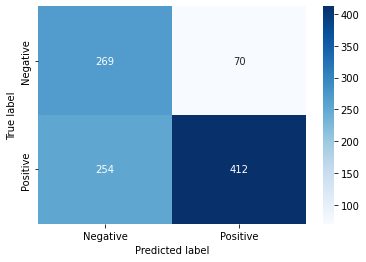

In [0]:
time.sleep(30) # let some more data come in before demonstrating metrics

gold_df = spark.read.format("delta").load(GOLD_DELTA)

# Extract predicted and actual labels
y_true = gold_df.select('sentiment_id').rdd.map(lambda row: row.sentiment_id).collect()
y_pred = gold_df.select('predicted_sentiment_id').rdd.map(lambda row: row.predicted_sentiment_id).collect()

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate precision, recall, and F1-score
tp = cm[1, 1]
fp = cm[0, 1]
fn = cm[1, 0]
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Log metrics to MLflow
with mlflow.start_run():

    # Log precision, recall, and F1-score as metrics
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1_score)

    # Log model name and MLflow version as parameters
    mlflow.log_param("model_name", MODEL_NAME)
    mlflow.log_param("mlflow_version", 1)

    # Log Delta Table version as parameter
    from delta.tables import DeltaTable
    delta_table = DeltaTable.forPath(spark, GOLD_DELTA)
    history_df = delta_table.history()
    latest_version = history_df.select("version").orderBy("version", ascending=False).first()[0]
    mlflow.log_param("delta_table_version", latest_version)

    sns.heatmap(cm, annot=True, cmap="Blues", fmt='g', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

## 8.0 Application Data Processing and Visualization
- How many mentions are there in the gold data total?
- Count the number of neutral, positive and negative tweets for each mention in new columns
- Capture the total for each mention in a new column
- Sort the mention count totals in descending order
- Plot a bar chart of the top 20 mentions with positive sentiment (the people who are in favor)
- Plot a bar chart of the top 20 mentions with negative sentiment (the people who are the vilians)

You may want to use the "Loop Application" widget to control whether you repeateded display the latest plots while the data comes in from your streams before moving on to the next section and cleaning up your run.

*note: A mention is a specific twitter user that has been "mentioned" in a tweet with an @user reference.

This is a sample application data visualization for grading/testing

In [0]:
gold_df = spark.read.format("delta").load(GOLD_DELTA)

# Calculate the number of mentions in the Gold Data
total_mentions = gold_df.select("mention").distinct().count()

# Count the number of neutral, positive, and negative tweets for each mention
mention_counts = gold_df.groupBy("mention") \
    .agg(
        min("timestamp").alias("min_timestamp"),
        max("timestamp").alias("max_timestamp"),
        sum(when(col("sentiment_id") == 0, 1).otherwise(0)).alias("negative"),
        sum(when(col("sentiment_id") == 1, 1).otherwise(0)).alias("positive"),
        sum(when(col("sentiment_id") == 2, 1).otherwise(0)).alias("neutral")
    )

# Calculate the total for each mention
mention_counts = mention_counts.withColumn("total", col("negative") + col("positive") + col("neutral"))

# Sort the mention count totals in descending order
sorted_mention_counts = mention_counts.orderBy(col("total").desc())

# Plot a bar chart of the top 20 mentions with positive sentiment
top_20_positive_mentions = sorted_mention_counts.filter(col("positive") > 0).limit(20).orderBy(col("positive").desc()).toPandas()
top_20_positive_mentions.plot(kind="bar", x="mention", y="positive", title="Top 20 Mentions with Positive Sentiment")
plt.show()

# Plot a bar chart of the top 20 mentions with negative sentiment
top_20_negative_mentions = sorted_mention_counts.filter(col("negative") > 0).limit(20).orderBy(col("negative").desc()).toPandas()
top_20_negative_mentions.plot(kind="bar", x="mention", y="negative", title="Top 20 Mentions with Negative Sentiment")
plt.show()

This is the Application Data Processing and Visualization that updates over time, although you need to let the other code run first if doing "run all". If you run the cells one by one, you can activate immediately and watch dynamic updating.

In [0]:
# Define a function to create a random plot
def create_plot():
    gold_df = spark.read.format("delta").load(GOLD_DELTA)

    # Calculate the number of mentions in the Gold Data
    total_mentions = gold_df.select("mention").distinct().count()

    # Count the number of neutral, positive, and negative tweets for each mention
    mention_counts = gold_df.groupBy("mention") \
        .agg(
            min("timestamp").alias("min_timestamp"),
            max("timestamp").alias("max_timestamp"),
            sum(when(col("sentiment_id") == 0, 1).otherwise(0)).alias("negative"),
            sum(when(col("sentiment_id") == 1, 1).otherwise(0)).alias("positive"),
            sum(when(col("sentiment_id") == 2, 1).otherwise(0)).alias("neutral")
        )

    # Calculate the total for each mention
    mention_counts = mention_counts.withColumn("total", col("negative") + col("positive") + col("neutral"))

    # Sort the mention count totals in descending order
    sorted_mention_counts = mention_counts.orderBy(col("total").desc())

    # Plot a bar chart of the top 20 mentions with positive sentiment
    top_20_positive_mentions = sorted_mention_counts.filter(col("positive") > 0).limit(20).orderBy(col("positive").desc()).toPandas()
    top_20_positive_mentions.plot(kind="bar", x="mention", y="positive", title="Top 20 Mentions with Positive Sentiment")
    plt.show()

    # Plot a bar chart of the top 20 mentions with negative sentiment
    top_20_negative_mentions = sorted_mention_counts.filter(col("negative") > 0).limit(20).orderBy(col("negative").desc()).toPandas()
    top_20_negative_mentions.plot(kind="bar", x="mention", y="negative", title="Top 20 Mentions with Negative Sentiment")
    plt.show()

# Define a function to update the plot
def update_plot(change):
    create_plot()

# Create a loop application widget
loop_button = widgets.ToggleButton(description='Start Loop', value=False)
output = widgets.Output()

def loop_event(change):
    while loop_button.value:
        with output:
            output.clear_output(wait=True)
            create_plot()
        time.sleep(10)

loop_button.observe(loop_event, 'value')

# Display the loop application widget
widgets.VBox([loop_button, output])


## 9.0 Clean up and completion of your pipeline
- using the utilities what streams are running? If any.
- Stop all active streams
- print out the elapsed time of your notebook.

In [0]:
end_program_immediately = False

# Printing active streams
print("Active Streams:")
if len(spark.streams.active) > 0:
    for stream in spark.streams.active:
        print(stream.name)
else:
    print("None")

# Get the notebooks ending time note START_TIME was established in the include file when the notebook started.
END_TIME = time.time()
print(f"Total time to run code to get streaming up and running: {END_TIME - START_TIME:.2f} seconds")

# Ending the application before streaming is finished
if not end_program_immediately:
    time.sleep(3600)
    gold_stream.awaitTermination() # in this case just wait or use widget to end program

stop_all_streams()
print("All streams stopped")
clear_previous_run()
print("Previous Run cleared")

Active Streams:
gold_stream
bronze_stream
silver_stream


In [0]:
# Get the notebooks ending time note START_TIME was established in the include file when the notebook started.
END_TIME = time.time()
print(f"Total time to run: {END_TIME - START_TIME:.2f} seconds")

## 10.0 How Optimized is your Spark Application (Grad Students Only)
Graduate students (registered for the DSCC-402 section of the course) are required to do this section.  This is a written analysis using the Spark UI (link to screen shots) that support your analysis of your pipelines execution and what is driving its performance.
Recall that Spark Optimization has 5 significant dimensions of considertation:
- Spill: write to executor disk due to lack of memory
- Skew: imbalance in partition size
- Shuffle: network io moving data between executors (wide transforms)
- Storage: inefficiency due to disk storage format (small files, location)
- Serialization: distribution of code segments across the cluster

Comment on each of the dimentions of performance and how your impelementation is or is not being affected.  Use specific information in the Spark UI to support your description.  

Note: you can take sreenshots of the Spark UI from your project runs in databricks and then link to those pictures by storing them as a publicly accessible file on your cloud drive (google, one drive, etc.)

References:
- [Spark UI Reference Reference](https://spark.apache.org/docs/latest/web-ui.html#web-ui)
- [Spark UI Simulator](https://www.databricks.training/spark-ui-simulator/index.html)

### ENTER YOUR MARKDOWN HERE